# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import time
import warnings

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
warnings.simplefilter(action='ignore')
%matplotlib inline

In [4]:
# Откроем файл и запишем датасет в переменную data
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
    
if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
# data = data.sample(20000, random_state=1)

In [6]:
# Посмотрим первые 10 строк датафрейма data
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [7]:
# Выведем общую информацию о датафрейме data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
# Проверим наличие явных дубликатов
data.duplicated().sum()

0

In [9]:
# Проверим баланс классов
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

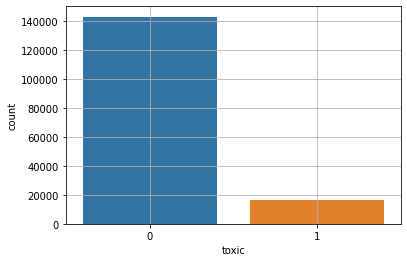

In [10]:
sns.countplot(data=data, x='toxic')
plt.title('')
plt.grid()

Токсичных комментариев гораздо меньше, чем позитивных или нейтральных

In [11]:
# Уберем лишние символы
text_column = data['text'].apply(lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).lower().split()))

In [12]:
text_column

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself that is a ho...
159289    spitzer umm theres no actual article for prost...
159290    and it looks like it was actually you who put ...
159291    and i really don t think you understand i came...
Name: text, Length: 159292, dtype: object

In [14]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
lemma_column = []

In [17]:
for column in text_column:
    sentence = column
    lemma_column.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]))

In [18]:
lemma_column = pd.Series(lemma_column)

In [19]:
lemma_column

0         explanation why the edits make under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not try to edit war it s ju...
3         more i can t make any real suggestion on impro...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm there no actual article for prosti...
159290    and it look like it be actually you who put on...
159291    and i really don t think you understand i come...
Length: 159292, dtype: object

In [21]:
# Проведем токенизацию текста
token_column = text_column.apply(lambda text: word_tokenize(text))

In [22]:
token_column[:5]

0    [explanation, why, the, edits, made, under, my...
1    [d, aww, he, matches, this, background, colour...
2    [hey, man, i, m, really, not, trying, to, edit...
3    [more, i, can, t, make, any, real, suggestions...
4    [you, sir, are, my, hero, any, chance, you, re...
Name: text, dtype: object

In [23]:
y = data['toxic']

In [24]:
# Разделим датафрейм на обучающую и тестовую выборку
text_train, text_test, y_train, y_test = train_test_split(lemma_column, y, test_size=0.2, random_state=12345)

In [25]:
# Загрузим список стоп-слов
stop_words = list(stopwords.words('english'))
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

***Вывод:***

Исходный набор текстовых данных подготовлен для задачи классификации: удалены лишние символы, произведена токенизация и лемматизация текста, сформирована отложенная выборка. 

## Обучение

Проверим несколько способов предварительной подготовки корпуса: с использованием мешка слов и параметра TF-IDF, с отсечением стоп-слов и без отсечения.
Подготовим соответствующие пайпланы и произведем оценку на модели логистической регрессии на кросс-валидации по обучающей выборке.

In [26]:
lgr_model = LogisticRegression(class_weight='balanced')

pipeline_cnt = make_pipeline(CountVectorizer(), lgr_model)
pipeline_cnt_stop = make_pipeline(CountVectorizer(stop_words=stop_words), lgr_model)

pipeline_tfidf = make_pipeline(TfidfVectorizer(), lgr_model)
pipeline_tfidf_stop = make_pipeline(TfidfVectorizer(stop_words=stop_words), lgr_model)

In [27]:
pipeline_list = [pipeline_cnt, pipeline_cnt_stop, pipeline_tfidf, pipeline_tfidf_stop]

In [28]:
for pipeline in pipeline_list:
    print(pipeline.get_params)

    start_time = time.time()
    f1 = cross_val_score(pipeline, X=text_train, y=y_train, cv=3, scoring='f1').mean()
    end_time = time.time()
    training_time = end_time - start_time

    print(f'F1-score = {round(f1, 2)}, training_time = {round(training_time, 1)}')
    print()

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])>
F1-score = 0.75, training_time = 139.0

<bound method Pipeline.get_params of Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression',
                 LogisticRegr

Применение стоп-слов немного ухудшает качество модели, практически не отражаясь на скорости обучения. При использовании TfidfVectorizer качество модели практически не зависит от стоп-слов. Метод CountVectorize обеспечивает более высокую метрику качества F1-score, по сравнению с TF-IDF.
Таким образом, наиболее предпочтитетельная подготовка вектора признаков в данном случае основана на использовании метода мешка слов без использования стоп-слов.

In [29]:
# Модель дерева решений
pipeline_dtf = make_pipeline(CountVectorizer(), DecisionTreeClassifier(random_state=12345, class_weight='balanced'))
cross_val_score(pipeline_dtf, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.58

In [30]:
# Логистическая регрессия с SGD
pipeline_sgd = make_pipeline(CountVectorizer(), SGDClassifier(random_state=12345, class_weight='balanced'))
cross_val_score(pipeline_sgd, X=text_train, y=y_train, cv=3, scoring='f1', n_jobs=-1).mean().round(2)

0.73

Качество моделеи дерево решений существенно ниже. Вариант лостической регрессии со стохастическим градиентным спуском показывает несколько меньшее значение метрики качества, однако существенно выигрывает во врмени.
Остановимся на моделях логистической регрессии, попробуем настроить гиперпараметры.

In [31]:
log_grid = {'logisticregression__C' : np.logspace(-2, 3, 10)}
log_search = GridSearchCV(estimator=pipeline_cnt, 
                            param_grid = log_grid, 
                            cv=3,
                            n_jobs = -1,
                            scoring='f1')
log_search.fit(text_train, y_train)
round(log_search.best_score_, 2)

0.76

In [32]:
sgd_grid = {'sgdclassifier__loss':['hinge', 'log'],
            'sgdclassifier__learning_rate':['optimal', 'adaptive'],
            'sgdclassifier__eta0':[0.05, 0.1, 0.2, 0.5]}
sgd_search = GridSearchCV(estimator=pipeline_sgd, 
                            param_grid = sgd_grid, 
                            cv=3,
                            n_jobs = -1,
                            scoring='f1')
sgd_search.fit(text_train, y_train)
round(sgd_search.best_score_, 2)

0.76

In [33]:
sgd_search.best_params_

{'sgdclassifier__eta0': 0.2,
 'sgdclassifier__learning_rate': 'adaptive',
 'sgdclassifier__loss': 'hinge'}

Подбор гиперпараметров немного повысил качество модели SGD.

In [34]:
%%time
log_search.best_estimator_.fit(text_train, y_train)
y_pred = log_search.best_estimator_.predict(text_test)
f1_score(y_test, y_pred)

CPU times: user 24.4 s, sys: 31.5 s, total: 55.9 s
Wall time: 56.1 s


0.755615696887686

In [35]:
%%time
sgd_search.best_estimator_.fit(text_train, y_train)
y_pred = sgd_search.best_estimator_.predict(text_test)
f1_score(y_test, y_pred)

CPU times: user 12 s, sys: 294 ms, total: 12.3 s
Wall time: 12.3 s


0.7650528048278701

Метрика F1 на тестовых данных, соответствует аналогичным показателям на обучающей выборке.

***Вывод:***

На модели логистической регрессии проверено несколько вариантов подготовки векторов признаков из исходного корпуса: с использованием мешка слов и TF-IDF, со стоп-словами и без. Выбран способ подготовки с использованием CountVectorizer, без стоп-слов. Проверено несколько других методов классификации: дерево решений и логистическая регрессия со стохастическим градиентным спуском.

## Выводы

***Вывод:***

Исходный набор текстовых данных подготовлен для задачи классификации: удалены лишние символы, произведена токенизация и лемматизация текста, сформирована отложенная выборка. На модели логистической регрессии проверено несколько вариантов подготовки векторов признаков из исходного корпуса: с использованием мешка слов и TF-IDF, со стоп-словами и без. Выбран способ подготовки с использованием CountVectorizer, без стоп-слов. Проверено несколько других методов классификации: дерево решений и логистическая регрессия со стохастическим градиентным спуском. Наилучшее значение метрики качества F1 на обучающей выборке на кросс-валидации получено на логистической регрессии, применение метода SGD несколько снижает качество, однако дает выигрыш в скорости расчета. Выбранные модели протестированы на отложенной выборке, метрика f1 составила 0,76, что соответствует качеству на обучающей выборке.